In [1]:
library(circlize)


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [21]:
plot_reciprocals = TRUE
plot_nonreciprocals = FALSE
plot_unknowns = FALSE

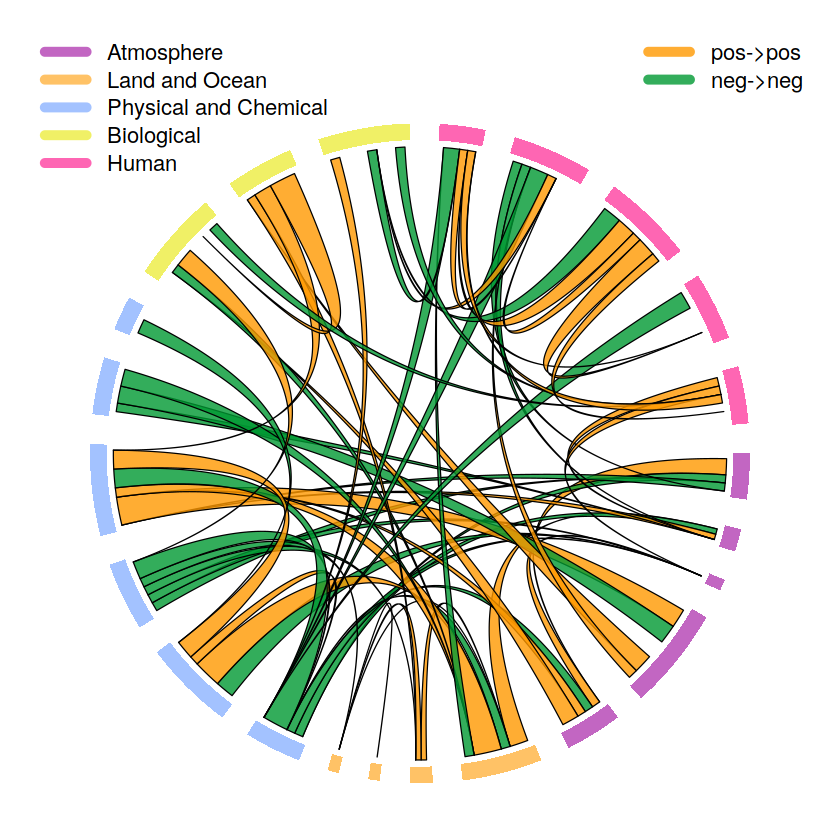

In [22]:
# create a matrix [0,1,2; 2,0,-1, -1,1,0]
mat = matrix(c(0,1,2, 2,0,-1, -1,1,0), nrow = 3, ncol = 3, byrow = TRUE)

# create a random matrix of size 10x10 that contains integers between -5 and 5 and 0 on the diagonal
mat = matrix(sample(c(-5:5,0), 100, replace = TRUE), nrow = 10, ncol = 10)
diag(mat) = 0

# read the matrix from a file
mat = read.table("matrix_decoded.csv", sep=";")
mat = as.matrix(mat
                )

zeros = mat
zeros[,] = 0
zeros[mat == 0] = 1

# separate the incognites, labeled with 0.5, from the known values
incognites = mat
incognites[,] = 0
incognites[mat == 0.5] = 1
incognites[mat == 0.9] = 1
incognites[mat == 0.1] = 1

incognites_pos = mat
incognites_pos[mat != 0.9] = 0
incognites_pos[mat == 0.9] = 1
mat[mat == 0.9] = 0

incognites_neg = mat
incognites_neg[mat != 0.1] = 0
incognites_neg[mat == 0.1] = 1
mat[mat == 0.1] = 0

incognites_zeros = mat
incognites_zeros[mat != 0.5] = 0
incognites_zeros[mat == 0.5] = 1
mat[mat == 0.5] = 0
# create a vector of integers from 1 to the number of rows of the matrix
items = 1:nrow(mat)

# create a vector of cumulative sums of the absolute values of the rows of the matrix, starting with 0
v1 = c(0, cumsum(apply(mat, 1, function(x) sum(abs(x)))))


# create a data frame that contains, for each item, one row for the start of the arc
# and one row for the end of the arc, using the vector of cumulative sums to determine the start and end points
df = data.frame(
    factor = rep(items, each = 2),
    x = rep(v1, each = 2)[2:(2*length(v1)-1)]
    )

# Create an auxuliary data frame that contains, for each item, the start and end points of the arc
data_start_end = data.frame(
    factor = items,
    start = v1[1:length(v1)-1],
    end = v1[2:length(v1)]
    )



# Initialize the plot.
par(mar = c(1, 1, 1, 1) ) 
total_gap = 120
gap_degree = total_gap /nrow(mat)
circos.par(gap.degree = gap_degree, "canvas.xlim" = c(-1, 1), "canvas.ylim" = c(-1, 1.2))
circos.initialize(factors = df$factor, x = df$x)


# Create a vector of N distinct colors (N = number of rows of the matrix) using pastel colors

atmos_col = rgb(153/255, 0/255, 153/255, 0.6)
land_ocean_col = rgb(255/255, 153/255, 0, 0.6)
phy_chem_col = rgb(102/255, 153/255, 255/255, 0.6)
bio_col = rgb(230/255, 230/255, 0/255, 0.6)
human_col = rgb(254/255, 0/255, 128/255, 0.6)

cols = c(atmos_col,
            atmos_col,
            atmos_col,
            atmos_col,
            atmos_col,
            land_ocean_col,
            land_ocean_col,
            land_ocean_col,
            land_ocean_col,
            phy_chem_col,
            phy_chem_col,
            phy_chem_col,
            phy_chem_col,
            phy_chem_col,
            phy_chem_col,
            bio_col,
            bio_col,
            bio_col,
            human_col,
            human_col,
            human_col,
            human_col,
            human_col
)



red = rgb(255/255, 51/255, 0/255, 0.8)
blue = rgb(51/255, 51/255, 255/255, 0.8)
pink = rgb(255/255, 153/255, 0/255, 0.8)
green = rgb(0/255, 153/255, 51/255, 0.8)

# Build the regions of track #1
circos.trackPlotRegion(factors = df$factor, ylim = c(0,1) ,bg.col = cols, bg.border = NA, track.height = 0.05)

h.ratio = 0.7


for (i in 1:nrow(mat)){
    i0 = data_start_end$start[i] # start of the arc at the source


    for (j in i:ncol(mat)) {
        if (i == j) next # skip the diagonal
        # print the source and target
        j0 = data_start_end$start[j] # start of the arc at the target
        val_ij = mat[i,j]
        val_ji = mat[j,i]
        width_ij = abs(val_ij)
        width_ji = abs(val_ji)


        # color is red for positive values, blue for negative values, black for 0
        

        col_ij = ifelse(val_ij > 0, red, ifelse(val_ij < 0, blue, "black"))
        col_ji = ifelse(val_ji > 0, red, ifelse(val_ji < 0, blue, "black"))

        if (col_ij == col_ji & col_ij == red) {
            # Reciprocal positive
            col_ij = col_ji = pink
            if (plot_reciprocals) {
                circos.link(i, c(i0, i0+width_ij), j, c(j0, j0+width_ji), col = col_ij, lwd = 1, lty = 1, border="black")
            }
        } else if (col_ij == col_ji & col_ij == blue) {
            # Reciprocal negative
            col_ij = col_ji = green
            if (plot_reciprocals) {
                circos.link(i, c(i0, i0+width_ij), j, c(j0, j0+width_ji), col = col_ij, lwd = 1, lty = 1, border="black")
            }
        } else {
            # Non-reciprocal
            if (width_ij > 0 & width_ji > 0) {
                if (plot_nonreciprocals) {
                    circos.link(i, c(i0, i0+width_ij), j, c(j0+width_ji, j0+width_ji), col = col_ij)
                    circos.link(i, c(i0+width_ij, i0+width_ij), j, c(j0, j0+width_ji), col = col_ji)
                    circos.link(i, c(i0, i0+width_ij), j, c(j0, j0+width_ji), col = rgb(0,0,0,0), lwd = 1, lty = 1, border="black" )
                }

            } else if (width_ij > 0 | width_ji > 0) {

                col_ij = ifelse(val_ij > 0, pink, col_ij)
                col_ij = ifelse(val_ij < 0, green, col_ij)
                col_ji = ifelse(val_ji > 0, pink, col_ji)
                col_ji = ifelse(val_ji < 0, green, col_ji)
                # edge in one direction
                if (plot_reciprocals) {
                    if (width_ij > 0) circos.link(i, c(i0, i0+width_ij), j, c(j0+width_ji, j0+width_ji), col = col_ij, lwd = 1, lty = 1, border="black" )
                    if (width_ji > 0) circos.link(i, c(i0+width_ij, i0+width_ij), j, c(j0, j0+width_ji), col = col_ji, lwd = 1, lty = 1, border="black" )
                }   
            } else if (width_ij == 0 & incognites[i,j] == 1) {
                # incognite
                if (plot_unknowns) {
                    col = ifelse(incognites_pos[i,j] == 1, red, ifelse(incognites_neg[i,j] == 1, blue, "black"))
                    circos.link(i, c(i0, i0), j, c(j0, j0), col = col, lwd = 2,lty = 1, directional = 1, border="black")
                }
            } else if (width_ji == 0 & incognites[j,i] == 1) {
                # incognite
                if (plot_unknowns) {
                    col = ifelse(incognites_pos[i,j] == 1, red, ifelse(incognites_neg[i,j] == 1, blue, "black"))
                    circos.link(i, c(i0, i0), j, c(j0, j0), col = col, lwd = 2,lty = 1, directional = 1, border="black")
                }
            }
        }
        
        # update the start of the arc at the target
        data_start_end$start[j] = j0 + width_ji
        i0 = i0 + width_ij
    }
    data_start_end$start[i] = i0
}

legend(
"topleft",
legend = c("Atmosphere", "Land and Ocean", "Physical and Chemical", "Biological", "Human"),
col = c(atmos_col, land_ocean_col, phy_chem_col, bio_col, human_col),
lty = c(1, 1, 1, 1, 1),
lwd = c(8, 8, 8, 8, 8),
bty = "n",
cex = 1.1,
ncol = 1
)

# legend(
# "topright",
# legend = c("pos->neg", "neg->pos", "pos->pos", "neg->neg", ">0", "<0", "~0"),
# col = c(red, blue, pink, green, red, blue, "black"),
# lty = c(1, 1, 1, 1, 1, 1, 1),
# lwd = c(8, 8, 8, 8, 1, 1, 1),
# bty = "n",
# cex = 1.1,
# ncol = 1
# )

legend(
"topright",
legend = c("pos->pos", "neg->neg"),
col = c(pink, green),
lty = c(1, 1),
lwd = c(8, 8),
bty = "n",
cex = 1.1,
ncol = 1
)

# legend(
# "topright",
# legend = c("pos->neg", "neg->pos"),
# col = c(red, blue),
# lty = c(1, 1),
# lwd = c(8, 8),
# bty = "n",
# cex = 1.1,
# ncol = 1
# )


# legend(
# "topright",
# legend = c(">0", "<0", "~0"), 
# col = c(red, blue, "black"),
# lty = 1,
# lwd = 1,
# bty = "n",
# cex = 1.1,
# ncol = 1
# )
# save the plot




circos.clear()


In [ ]:
rownames(mat) = colnames(mat) = 1:nrow(mat)

df = data.frame(from = rep(rownames(mat), times = ncol(mat)),
    to = rep(colnames(mat), each = nrow(mat)),
    value = as.vector(mat),
    stringsAsFactors = FALSE
    )

df
# Create a vector of N distinct colors (N = number of rows of the matrix) using pastel colors

from,to,value
<chr>,<chr>,<int>
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


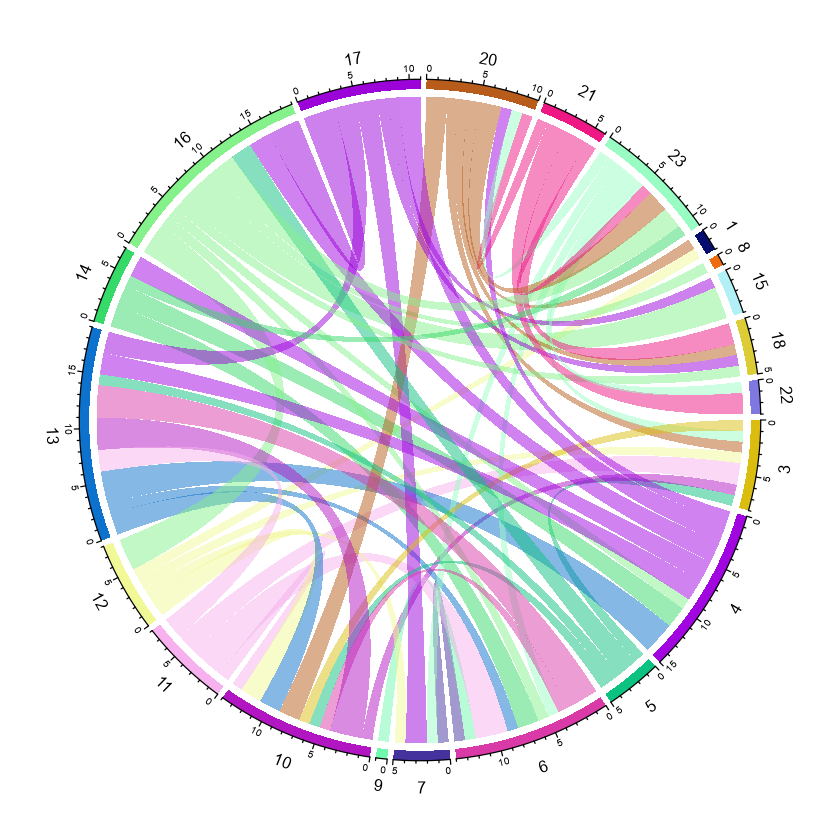

In [ ]:
chordDiagram(mat)